In [3]:
options(dplyr.summarise.inform = FALSE)
library(tidyverse)
library(data.table)
library(survival)
library(gridExtra)

In [4]:
source(paste0(dirname(dirname(dirname(getwd()))),'/map.r'))
source(paste0(dirname(dirname(dirname(getwd()))),'/stats.r'))

#### 0 - Run analyses

In [121]:
system.time(go <- readRDS(paste0(SHARE_DIR, "ready_ex.Rds")))

   user  system elapsed 
  1.797   0.132   3.075 

- Extract data

In [199]:
df <- go$data_ready
features <- go$features
top_zscores <- unique(fread(paste0(UTIL_DIR, "zscores_tmp2.csv")) %>% pull(y))#, "rna_geneset_gene_set_prolif")

- Set cohorts 

In [193]:
df_go <- 
df %>% 
  mutate( location = ifelse(grepl("Unknown", clin_primaryTumorLocation2), "CUP", clin_primaryTumorLocation2))

In [194]:
cohorts <- df_go %>% group_by(location) %>% summarise(ct = n()) %>% filter(ct > 50) %>% pull(location)

In [195]:
cohort_dfs <- list()
for( i in cohorts ){
  cohort_dfs[[i]] <- df_go %>% filter( location == i ) 
}

#### 1 - Go for a run

- Survival, test everything

In [200]:
results <- data.frame()
system.time(
for( j in names(cohort_dfs)){
  df <- cohort_dfs[[j]]
  for( i in c(top_zscores)){
      tmp_results <- get_stats2( y = "Surv(Y_os_days, Y_os_event)", 
                      x = i, 
                      covariate = " + clin_age + clin_sex", 
                      data = "df", 
                      model = "coxph")
    
    if( is.data.frame(tmp_results)){ 
        results <- rbind(results, tmp_results %>% mutate(cohort = j))
    }
}})

   user  system elapsed 
  1.821   0.000   1.822 

In [238]:
scanner <- 
function( y = "Surv(Y_os_days, Y_os_event)", features, covariates, df = "df", mod = "coxph"){
    oo <- data.frame()
    for( f in features ) {
      tmp <- get_stats2( y = y, x = f, covariate = covariates, data = df, model = mod )
      if( is.data.frame(tmp)) oo <- rbind( oo, tmp)
    }
    oo
}

In [233]:
scanner( "clin_purity", top_zscores, " + clin_age + clin_sex", "df", "lm")

Warning message in glm.fit(x = structure(numeric(0), dim = c(0L, 4L), dimnames = list(:
“no observations informative at iteration 1”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in glm.fit(x = structure(numeric(0), dim = c(0L, 4L), dimnames = list(:
“no observations informative at iteration 1”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in glm.fit(x = structure(numeric(0), dim = c(0L, 4L), dimnames = list(:
“no observations informative at iteration 1”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in glm.fit(x = structure(numeric(0), dim = c(0L, 4L), dimnames = list(:
“no observations informative at iteration 1”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in glm.fit(x = structure(numeric(0), dim = c(0L, 4L), dimnames = list(:
“no observations informative at iteration 1”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in glm.fit(x = structure(numeric(0), dim = c

y,x,covariate,type,data,model,est,se,pval,lrt_pval
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
clin_purity,rna_mp_zscore_Malignant_MP26_NPC_Glioma,+ clin_age + clin_sex,rna,df,lm,0.09815256,0.05638719,8.733031e-02,4.194475e-05
clin_purity,rna_mp_zscore_Macrophage_MAC2,+ clin_age + clin_sex,rna,df,lm,0.13546282,0.71075118,8.495478e-01,1.264781e-04
clin_purity,rna_mp_zscore_Macrophage_Interferon,+ clin_age + clin_sex,rna,df,lm,-0.46541706,0.36000448,2.014817e-01,6.895380e-05
clin_purity,rna_mp_zscore_Malignant_MP3__Cell_Cylce_HMG_rich,+ clin_age + clin_sex,rna,df,lm,0.38255795,0.08807579,6.080358e-05,2.051280e-07
clin_purity,rna_mp_zscore_Macrophage_MAC1,+ clin_age + clin_sex,rna,df,lm,-0.23498001,0.28179702,4.079654e-01,9.893588e-05
clin_purity,rna_mp_zscore_Malignant_MP36_IG,+ clin_age + clin_sex,rna,df,lm,0.31158972,0.34629000,3.721526e-01,9.482403e-05
clin_purity,rna_mp_zscore_Malignant_MP15_EMT_IV,+ clin_age + clin_sex,rna,df,lm,-0.40518667,0.12015136,1.370487e-03,2.285537e-06
clin_purity,rna_mp_zscore_Malignant_MP35_Hemato_related_I,+ clin_age + clin_sex,rna,df,lm,-0.37011870,0.16594631,2.982351e-02,2.082599e-05
clin_purity,rna_mp_zscore_T_cell_CD8_Unassigned1,+ clin_age + clin_sex,rna,df,lm,-0.55497513,0.15337263,6.452504e-04,1.292405e-06


In [226]:
x

<0 x 0 matrix>

In [201]:
options(repr.plot.width = 16)

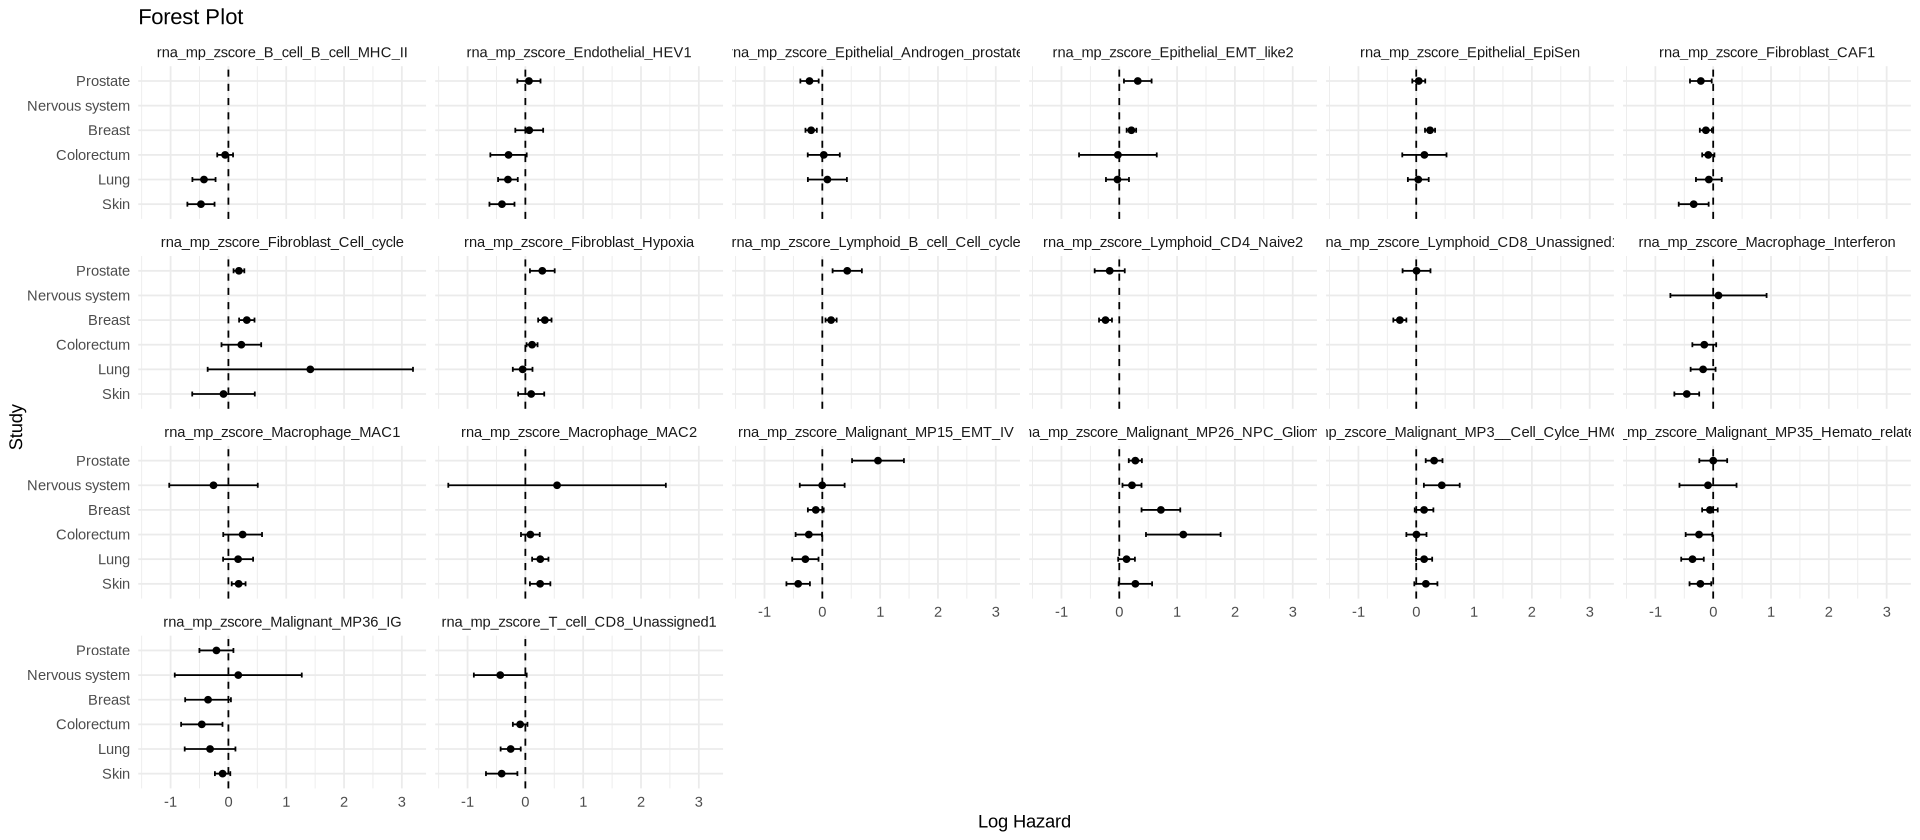

In [202]:
ggplot(results, aes(x = est, y = reorder(cohort, est))) +
  geom_point() +
  geom_errorbarh(aes(xmin = est - 2*se, xmax = est + 2*se), height = 0.2) +
  labs(x = "Log Hazard", y = "Study", title = "Forest Plot") +
  theme_minimal() +
  facet_wrap(~x, ncol = 6) + 
  geom_vline(xintercept = 0, linetype = "dashed")


#### 2 - Relations with top Z-scores

- Linear model with proliferation

In [ ]:
lms <- data.frame()

for(j in top_zscores){
  print(j); flush.console()
  for( i in features){
    for( k in names(cohort_dfs)){
      df <- cohort_dfs[[k]]

      tmp_lms <- get_stats2( y = j, 
                 x = i, 
                 covariate = "+ clin_age + clin_sex", 
                 data = "df", 
                 model = "lm")
    
    if( is.data.frame(tmp_lms)){ 
        lms <- rbind(lms, tmp_lms %>% mutate(cohort = j))
    }  
}}}

In [ ]:
lms <- lms %>% mutate(pval_by = p.adjust(pval, method = "BY")) 

In [49]:
fwrite(lms, paste0(UTIL_DIR, "zscores_tmp2.csv"))